In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import json
import pickle # read that in python3 pickle uses cpickle where possible

import time
from tqdm import tqdm
import datetime as dt
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 10)

In [3]:
# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing

# Loading data from json and creating DataFrame

In [4]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,5)]

if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Create one dataframe containing all data without duplicates

Having separate dataframes for each party only makes limited sense: many parties are mentioned more than once, thus there are many duplicates in the data. Whether only one party is mentioned in a given tweet can be deduced from the subsequently created columns 'tags', 'mentions', and 'parties'.

In [5]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(data) # name of new dataframe created
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Feature extraction and first clustering - 'quick and dirty'
1. Vectorization and standardization
2. Dimensionality reduction
3. Clustering

In [9]:
vectorizer = CountVectorizer() # transforms text data to sparse vector of numbers
scaler = StandardScaler(with_mean = False) # standardises the numbers -> values with mean 0 and std of 1
svd = TruncatedSVD(n_components = 1000, 
                   random_state = 123) # dimensionality reduction; svd can handle sparse data, PCA can't

preprocessing_pipe = Pipeline(steps = [('vectorizer', vectorizer), 
                                       ('scaler', scaler), 
                                       ('svd', svd)])



kmeans_clsf = KMeans(n_clusters=3, # number of desired clusters
                     random_state=123, 
                     n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
                     init='random', 
                     max_iter=50, # max number of iterations per single run
                     tol=1e-04) # controls tolerance with regard to the changes in the within-cluster sse to declare convergence

In [13]:
def first_clustering(dict_of_df):
    parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene']
    X = {}
    y_km = {}
    text = {}
    centers = {}
    
    
    for party in parties:
        df = data[party]
        text[party] = (df.loc[:, 'full_text']).tolist()

        X[party] = preprocessing_pipe.fit_transform(text[party])

        y_km[party] = kmeans_clsf.fit_predict(X[party])
        centers[party] = kmeans_clsf.cluster_centers_
        
    return X, y_km, centers

In [14]:
X, y_km, centers = first_clustering(data)

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConvers

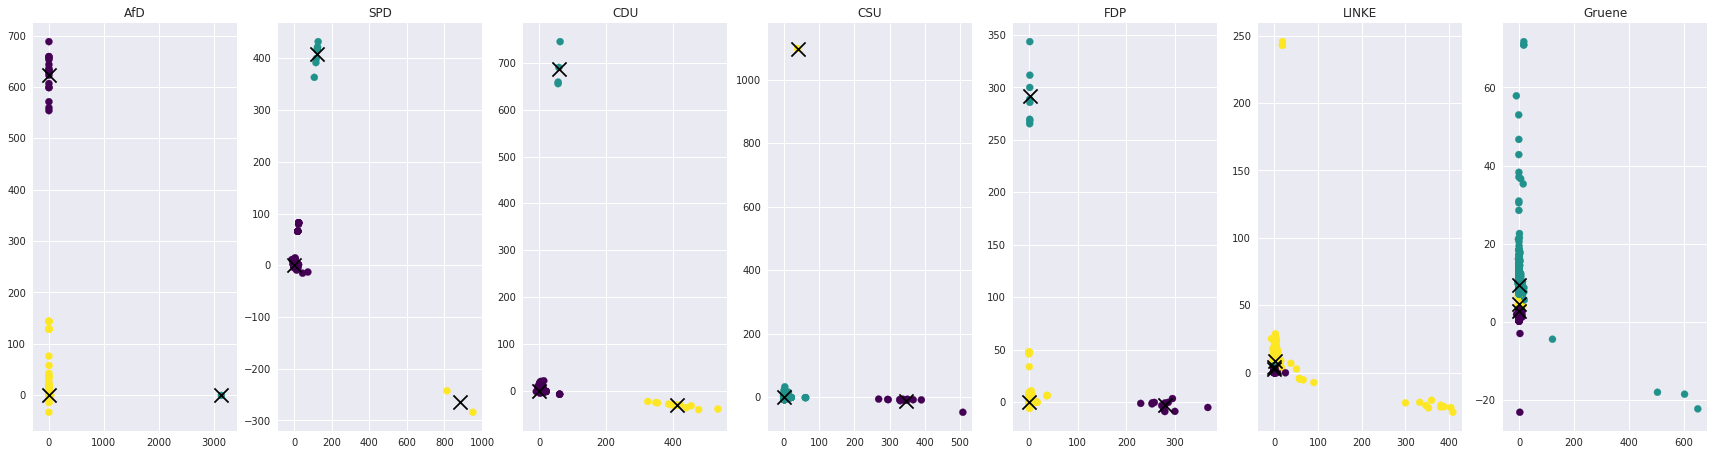

In [15]:
f, axarr = plt.subplots(1, 7, figsize=(30, 7.5))
parties_short = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene']

for i, party in enumerate(parties_short):
    ax = axarr[i]
    
    ax.scatter(X[party][:, 0], X[party][:, 1], c=y_km[party], s=50, cmap='viridis')
    ax.set_title(party)

    center = centers[party]
    ax.scatter(center[:, 0], center[:, 1], c='black', s=200, marker='x');

# Quick and dirty clustering full dataframe

1. Elbow visualizer to define number of clusters
2. KMeans for full dataframe

In [15]:
def text_preprocessing(df):
    
    """prepare text for the ElbowVisualizer """
    X2 = {}
    
    text = (df.loc[:, 'full_text']).tolist()

    X2 = preprocessing_pipe.fit_transform(text)
        
    return X2

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f3c2304a8>,
         k=None, metric=None, model=None, timings=True)

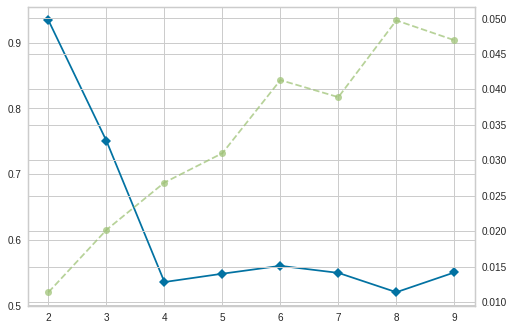

In [53]:
"""Use the elbow visualizer to find the optimal number of clusters for KMeans"""

from yellowbrick.cluster import KElbowVisualizer

X3 = text_preprocessing(all_data)
X3_short = X3[:1000] # take only the first 1000 > ran out of memory using all data

visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=[2, 10])
visualizer.fit(X3_short)

In [45]:
""" define KMeans with the optimal number of clusters derived from the elbow visualizer"""

kmeans_clsf2 = KMeans(n_clusters=4, # number of desired clusters
                     random_state=123, 
                     n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
                     init='random', 
                     max_iter=50, # max number of iterations per single run
                     tol=1e-04) # controls tolerance with regard to the changes in the within-cluster sse to declare convergence

In [50]:
def second_clustering(df):
    """
    Function used to prepare text data for KMeans classifier (use preprocessing pipelins) 
    and to apply KMeans 
    returns feature "coordinates" (X2), cluster (y_km2), and cluster centers (centers2)
    """
    
    
    X2 = {}
    y_km2 = {}
    centers2 = {}

    text = (df.loc[:, 'full_text']).tolist()

    X2 = preprocessing_pipe.fit_transform(text)

    y_km2 = kmeans_clsf2.fit_predict(X2)
    centers2 = kmeans_clsf2.cluster_centers_
        
    return X2, y_km2, centers2

In [51]:
X2, y_km2, centers2 = second_clustering(all_data)

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



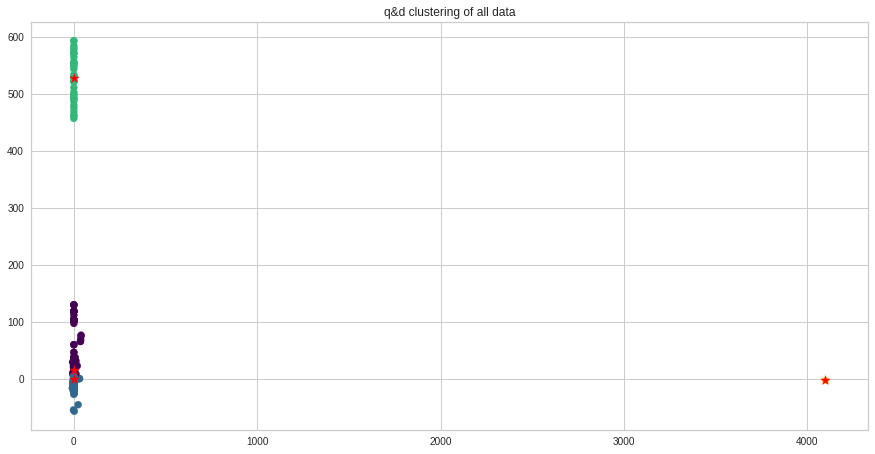

In [57]:
""" Plot features, cluster and cluster centers"""

plt.figure(figsize=(15, 7.5))
plt.scatter(X2[:, 0], X2[:, 1], c=y_km2, s=50, cmap='viridis')
plt.scatter(centers2[:, 0], centers2[:, 1], c='red', s=100, marker='*')
plt.title('q&d clustering of all data')
plt.show()

# Extract hashtags and party mentions
Create columns 'tags', 'clean_text', 'mentions', and 'parties'

- tags: hashtags found in the full tweet
- parties: parties mentioned without hashtag
- clean_text: hashtags and special characters removed from full_text

In [6]:
df_processing(all_data)

In [7]:
all_data.info()
all_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96031 entries, 2018-08-02 00:00:14 to 2018-08-04 20:58:07
Data columns (total 6 columns):
id_str        96031 non-null int64
full_text     96031 non-null object
tags          96031 non-null object
mentions      96031 non-null object
clean_text    96031 non-null object
parties       96031 non-null object
dtypes: int64(1), object(5)
memory usage: 5.1+ MB


,id_str,full_text,tags,mentions,clean_text,parties
created_at,,,,,,
2018-08-02 00:00:14,1024807045411889152,@BILD Für Sami A macht man Rundflüge. gute Migranten Flüchtlinge weißt man aus Demokratie versteht man hier nicht ☝️☝️#CSU #AfD #Bild #CSU #Bild #CSU #SPD #FDP #AFD #Bild #CSU #Bild #CSU #SPD #FDP...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD, Bild, CSU, Bild, CSU, SPD, FDP, AFD, Bild]",[BILD],Für Sami A macht man Rundflüge gute Migranten Flüchtlinge weißt man aus Demokratie versteht man hier nicht CSU AfD Bild CSU Bild CSU SPD FDP AFD Bild C...,"[AfD, SPD, CSU, FDP]"
2018-08-02 00:00:32,1024807122498924544,@bembelpix @AfD_Hessen NoAFD schreiben aber keine Argumente liefern warum man die AFD nicht wählen sollte.,[],"[bembelpix, AfD_Hessen]",Hessen NoAFD schreiben aber keine Argumente liefern warum man die AFD nicht wählen sollte,[AfD]
2018-08-02 00:00:32,1024807122666762240,RT @Walnusskipferl: @AssetsKater72 @dr_ecksack_ @incersu @MalteKaufmann Ich kenne nur die REPs Baden-Württemberg.\nDort trifft das zu. Die A…,[],"[Walnusskipferl, AssetsKater72, dr_ecksack_, incersu, MalteKaufmann]",RT ecksack Ich kenne nur die REPs Baden Württemberg Dort trifft das zu Die A,[]
2018-08-02 00:01:33,1024807378573832192,@NeotherealNeo @vonduessel @AfD @AndreasKalbitz Drittens in kauf nehmen ist ungleich wollen...\nWenn ich also bergsteige nehme ich in kauf das ich abstürze und sterbe ich will deshalb aber nicht a...,[],"[NeotherealNeo, vonduessel, AfD, AndreasKalbitz]",Drittens in kauf nehmen ist ungleich wollen Wenn ich also bergsteige nehme ich in kauf das ich abstürze und sterbe ich will deshalb aber nicht abstürzen und s...,[]
2018-08-02 00:02:08,1024807525621948416,Damit wir die Werte #AfD besser verstehen. #AfDwirkt https://t.co/t3tme5mTId,"[AfD, AfDwirkt]",[],Damit wir die Werte AfD besser verstehen AfDwirkt https t co t3tme5mTId,[AfD]


# Feature extraction: finetuning for clustering without the q&d

- hash the tags
- vectorize the text

In [8]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [9]:
with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)

In [98]:
f_hasher_small = FeatureHasher(n_features=100)
f_hasher_large = FeatureHasher(n_features=1000)

tfidfer = TfidfVectorizer(decode_error='strict', # {‘strict’, ‘ignore’, ‘replace’} - what to do if byte sequence given contains characters not of the given encoding
                          ngram_range=(2, 3),
                          stop_words=stopwords_de,
                          dtype=float)

scaler = StandardScaler(with_mean=False)
decomp_high = TruncatedSVD(n_components=500,
                           random_state=123)
 
decomp_low = TruncatedSVD(n_components=3,
                          random_state=123)

kmeans = KMeans(n_clusters=8, # number of desired clusters
                random_state=123, 
                n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
                init='random', 
                max_iter=50, # max number of iterations per single run
                tol=1e-04) # controls tolerance with regard to the changes in the within-cluster sse to declare convergence)

In [53]:
hash_linesmall = Pipeline(steps = [('hashing', f_hasher_small)])
hash_linelarge = Pipeline(steps = [('hashing', f_hasher_large)])
embedding_line = Pipeline(steps = [('word_embedder', tfidfer),
                                   ('scaling', scaler),
                                   ('decomp1', decomp_high)])

In [54]:
feature_mapper = DataFrameMapper([('tags', hash_linelarge),
                                 ('mentions', hash_linelarge),
                                 ('parties', hash_linesmall),
                                 ('clean_text', embedding_line)])

In [55]:
full_pipeline = Pipeline([('mapper', feature_mapper),
                          ('kmeans', kmeans)])

In [57]:
transformed = feature_mapper.fit_transform(all_data)

ValueError: clean_text: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [36]:
all_data.keys()

Index(['id_str', 'full_text', 'tags', 'mentions', 'clean_text', 'parties'], dtype='object')

In [86]:
text = tfidfer.fit_transform(all_data.iloc[:1000, 1])

In [87]:
text.shape

(1000, 10532)

In [88]:
type(text)

scipy.sparse.csr.csr_matrix

In [89]:
new_text = text.toarray()

In [41]:
new_text

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [91]:
transformed1 = scaler.fit_transform(tfidfer.fit_transform(all_data.loc[:, 'full_text']))

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7ff171017208>,
         k=None, metric=None, model=None, timings=True)

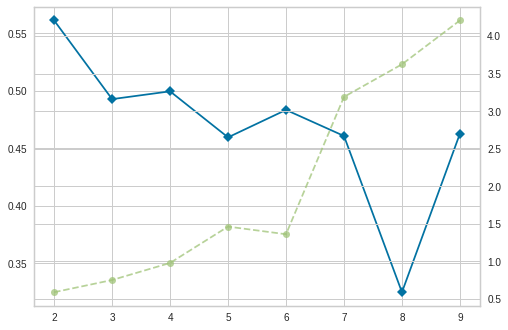

In [92]:
visualizer = KElbowVisualizer(KMeans(random_state=123), metric='silhouette', k=[2, 10])
visualizer.fit(to_fit)

In [93]:
y_km = kmeans.fit_predict(to_fit)

In [94]:
centers = kmeans.cluster_centers_

In [99]:
X = decomp_low.fit_transform(transformed1)

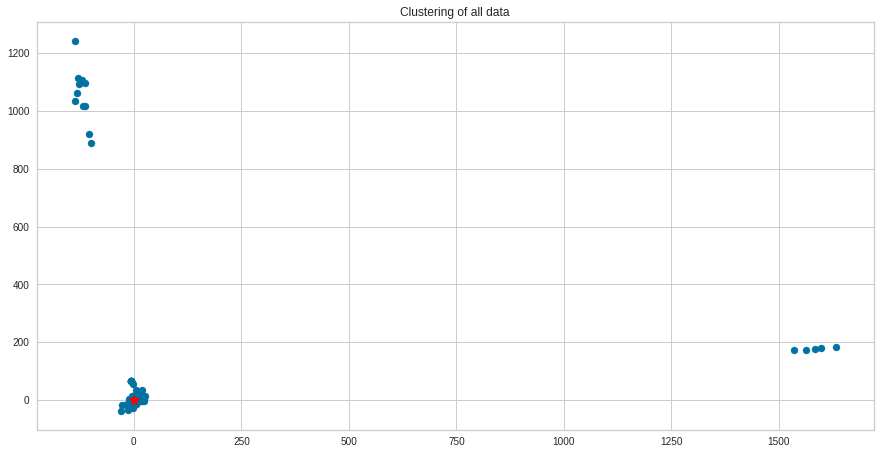

In [100]:
""" Plot features, cluster and cluster centers"""

plt.figure(figsize=(15, 7.5))
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='*')
plt.title('Clustering of all data')
plt.show()

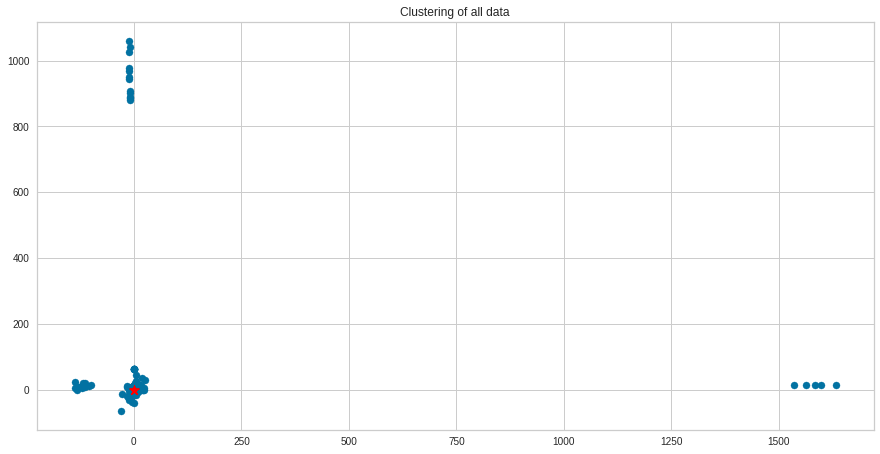

In [101]:
""" Plot features, cluster and cluster centers"""

plt.figure(figsize=(15, 7.5))
plt.scatter(X[:, 0], X[:, 2], s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='*')
plt.title('Clustering of all data')
plt.show()

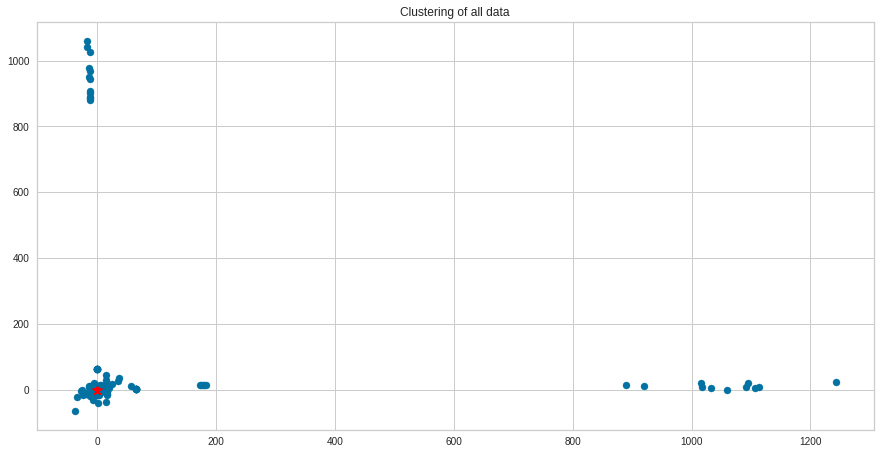

In [102]:
""" Plot features, cluster and cluster centers"""

plt.figure(figsize=(15, 7.5))
plt.scatter(X[:, 1], X[:, 2], s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='*')
plt.title('Clustering of all data')
plt.show()